In [1]:
import cv2
import random, os, sys, shutil
import numpy as np
from sklearn.cluster import KMeans
from skimage import io
from skimage import color
from PIL import Image, ImageOps
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from urllib.request import urlopen
from datetime import datetime
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [2]:
!pip install -U scikit-learn

#### Loading Data

In [3]:
#Path to folder
path_to_images = "../AI-4-Media-23-24/data/my-data/my-classification-dataset/class-"
#image extension
file_type = ".jpg"
#Pick image size
img_height = 224
img_width = 224
#Is it rgb or black and white?
channels = 3

In [4]:
paths = []
folders = 3
for i in range(1, folders+1):
    temp_path = path_to_images + str(i)
    print(temp_path)
    for root, dirs, files in os.walk(temp_path, topdown=False):
        for index, name in enumerate(files):
            if index >= 200:
                continue
            if file_type in name.lower():
                paths.append(str(os.path.join(root, name)))

#Load in images
# dataset = [np.array(img_to_array(load_img(i,target_size=((img_height,img_width)))))/255.0 for i in paths]
# dataset = np.array(dataset).astype("float32")
# dataset.shape
print(len(paths))
            

../AI-4-Media-23-24/data/my-data/my-classification-dataset/class-1
../AI-4-Media-23-24/data/my-data/my-classification-dataset/class-2
../AI-4-Media-23-24/data/my-data/my-classification-dataset/class-3
534


#### Oringinally Colour Palette Code
modified to take the average and ``KMeans(n_cluster = 1)``

In [5]:
def resize_image(image):
  height, width = image.shape[:2]
  max_height = 200
  max_width = 200

  # only shrink if img is bigger than required
  if max_height < height or max_width < width:
      # get scaling factor
      scaling_factor = max_height / float(height)
      if max_width/float(width) < scaling_factor:
          scaling_factor = max_width / float(width)
      # resize image
      resized_image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

  return resized_image

def get_colour_palettes(image_data):
  kmeans_rgb = []
  ind_average_rgb = []

  for i in image_data:
    image = io.imread(i)
    if len(image.shape) != 3:
      continue
    # print(image.shape)
    image = resize_image(image)
    avg = np.array(np.mean(image, axis=(0, 1)))
    ind_average_rgb.append(avg)
    # ind_average_rgb = np.append(ind_average_rgb, avg)
    image = image.reshape((image.shape[1]*image.shape[0],3))
    # print(image)
    kmeans = KMeans(n_clusters=1).fit(image)
    labels = kmeans.labels_
    labels=list(labels)
    centroid = kmeans.cluster_centers_

    percent = []
    for i in range(len(centroid)):
      j = labels.count(i)
      j = j/(len(labels))
      percent.append(j)

    # rgb = np.array(centroid/255)
    rgb = centroid

    percent_idx = np.array(percent).argsort()
    rgb_sorted = rgb[percent_idx[::-1]]

    kmeans_rgb.append(rgb_sorted)

    red, green, blue = zip(*image)
    height, width = image.shape

    pixel_count = height * width
    # ind_average_rgb.append((sum(red) / pixel_count, sum(green) / pixel_count, sum(blue) / pixel_count))
    

  kmeans_lab = color.rgb2lab(kmeans_rgb)
  k_lab = [i.flatten() for i in kmeans_rgb]
  # average_lab = color.rgb2lab(ind_average_rgb)
  # a_lab = [i.flatten() for i in ind_average_rgb]

  # print(result)

  return k_lab, ind_average_rgb

#### Checking the Difference Between Average and n_cluster=1 Result

In [6]:
kmeans_lab, average_rgb = get_colour_palettes(paths)
print(kmeans_lab)
print(average_rgb)

[array([ 41.8573913 ,  30.29447205, 133.4913354 ]), array([111.79415625,  70.9416875 , 104.58459375]), array([20.06321705, 19.31104651, 78.32899225]), array([64.852     , 75.79004348, 63.67143478]), array([104.45262048,  59.62560241,  86.59463855]), array([100.33725   ,  56.40784375, 120.60503125]), array([28.08251701, 43.38408163, 33.20751701]), array([126.79005 ,  91.562325, 113.3499  ]), array([60.35271875, 67.4295    , 45.11078125]), array([106.6695   ,  65.9483125, 144.40025  ]), array([40.12560241, 49.59807229, 64.7473494 ]), array([32.51702532, 29.71949367, 25.73550633]), array([42.52835443, 34.52050633, 33.07050633]), array([60.13765823, 44.30272152, 36.64088608]), array([ 71.82629464, 100.26821429, 122.41058036]), array([26.5915    , 25.88826667, 32.83236667]), array([88.83384375, 35.89446875, 37.23821875]), array([106.98715625,  71.1355625 , 115.275875  ]), array([ 74.6369375,  85.37425  , 104.944    ]), array([ 62.01140909,  91.627     , 137.2905    ]), array([ 91.88970803, 

2.003470593227988e-12


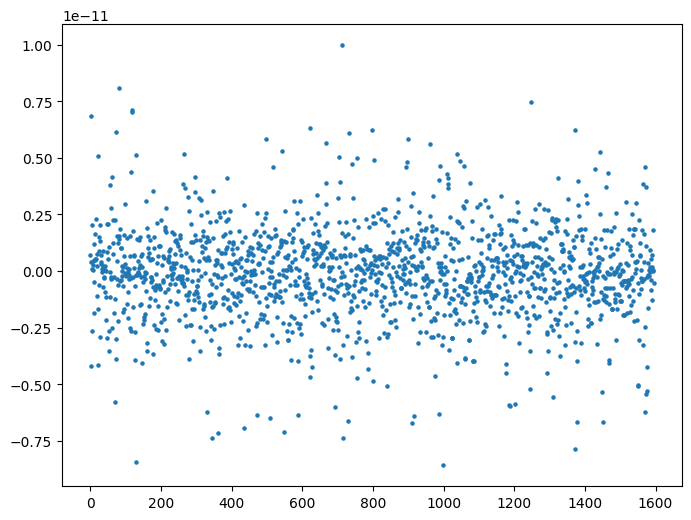

In [11]:
x = np.array(kmeans_lab)
y = np.array(average_rgb)
# if np.array_equal(x, y):
#     print("Hell yeah")
# else:
#     print("nope")
differences = np.array(x) - np.array(y)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(len(differences) * 3),differences, s = 5)
# plt.figure(figsize=(8, 6))
# plt.plot(differences, 'bo-', label='Differences')

differences = np.std(differences)
print(differences)



In [44]:
# print(np.shape(np.asarray(colour_palettes)))

#### 3D Plots

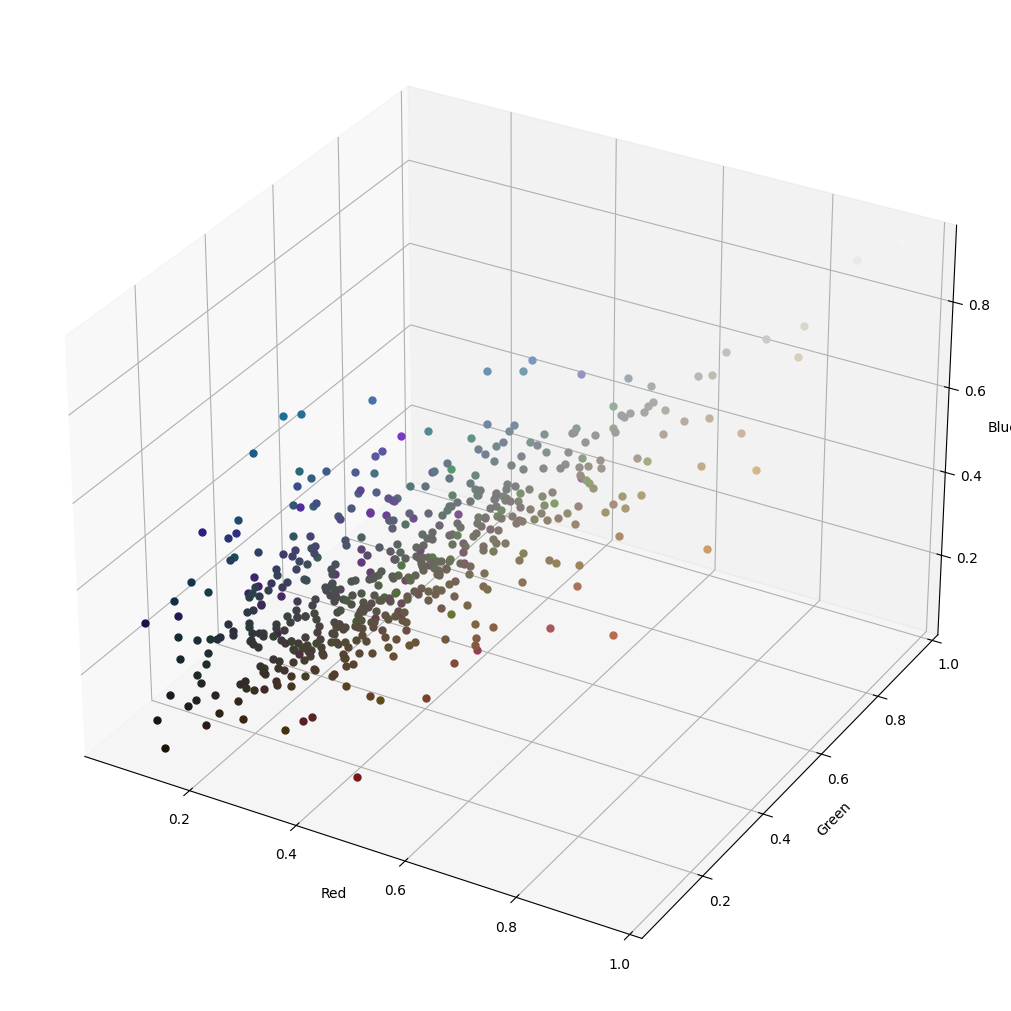

In [109]:
fig = plt.figure(figsize=(12,10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in kmeans_lab:
    colour = (i[0],i[1],i[2])
    # colour = (i[0]/255, i[1]/255, i[2]/255)
    # ax.view_init(20, 45)

    ax.plot(i[0], i[1], i[2], c = colour, marker='o', markersize=5)
    # ax.set_xbound(0,255)
    # ax.set_ybound(0,255)
    # ax.set_zbound(0,255)

    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")

In [8]:
def average(image_data):
    average_color = []
    for i in image_data:

        image = Image.open(i)
        if len(image.mode) != 3:
            continue
        image = ImageOps.contain(image, (200,200))
        image = image.convert(mode='LAB')
        # image = resize_image(image)
        pixels = image.getdata()
        red, green, blue = zip(*pixels)
        result = (sum(red) / len(pixels), sum(green) / len(pixels), sum(blue) / len(pixels))
        print(result)
        average_color.append(result)
        
    return average_color


In [9]:
average = average(paths)
# print(np.shape(np.asarray(average)))

(54.25872670807453, 157.4535403726708, 76.48869565217392)
(92.50346875, 149.7136875, 117.4905625)
(29.810503875968994, 143.4518992248062, 96.24988372093023)
(76.4544347826087, 123.59108695652174, 133.98139130434782)
(81.4341265060241, 150.11213855421687, 122.27524096385542)
(82.287375, 156.6806875, 101.01359375)
(41.404931972789115, 120.84557823129252, 131.9043537414966)
(110.256825, 145.69075, 123.143425)
(69.478125, 123.2624375, 140.53809375)
(91.6899375, 157.0668125, 92.441125)
(50.952831325301204, 128.04656626506025, 118.114578313253)
(31.021455696202533, 129.43284810126582, 130.94791139240508)
(38.25202531645569, 132.74189873417723, 130.8992405063291)
(50.24151898734177, 134.71272151898734, 135.41715189873418)
(103.19611607142858, 122.55834821428572, 112.26267857142857)
(29.682266666666667, 131.08803333333333, 125.355)
(57.34371875, 152.07628125, 139.36259375)
(89.5626875, 149.21984375, 109.25984375)
(92.81384375, 131.2209375, 117.9545)
(98.56240909090909, 129.61318181818183, 100.

In [8]:
# from mpl_toolkits.mplot3d import Axes3D
# def plot_umap(feature_type, features, n_neighbors, min_dist):

#   reducer = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, n_components=3)

#   pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
#   embedding = pipe.fit_transform(features)
#   test = np.asarray(embedding)
#   print(np.shape(test))
#   # added third embedding
#   tx, ty, tz = embedding[:,0], embedding[:,1], embedding[:,2]
#   print(len(tx), len(ty), len(tz))
#   print(tx[2], ty[2], tz[2])
#   tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
#   ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
#   # third dim
#   tz = (tz-np.min(tz)) / (np.max(tz) - np.min(tz))

#   width = 4000
#   height = 3000
#   depth = 3000
#   max_dim = 100

#   full_image = Image.new('RGBA', (width, height))
#   for img, x, y, z in zip(paths, tx, ty, tz):
#       tile = Image.open(img)
#       rs = max(1, tile.width/max_dim, tile.height/max_dim)
#       tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.Resampling.LANCZOS)
#       full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

#   # plt.figure(figsize = (16,12))

#   fig = plt.figure(figsize=(16, 12))
#   ax = fig.add_subplot(111, projection='3d')

#   # Plot the image tiles as scatter points in 3D space
#   ax.scatter(tx, ty, tz, c='blue', s=1, alpha=0.8)

#   # Adjust the view angle for better visualization
#   # ax.view_init(30, 45)  # Elevate and rotate the view
#   full_image.save("images/UMAP_" + feature_type + '_nn=' + str(n_neighbors) + '_md=' + str(min_dist) + '_' + str(datetime.now().strftime("%Y%m%d-%H%M%S")) + ".png")
#   return ax.imshow(full_image)

#### UMAP reduced to n_components = 3 and mapped in 3D

In [41]:
def plot_umap(feature_type, features, n_neighbors, min_dist):

  reducer = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, n_components = 3)

  pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
  embedding = pipe.fit_transform(features)
  # print(pipe.intertia_)

  test = np.asarray(embedding)
  print(np.shape(test))
  tx, ty = embedding[:,0], embedding[:,1]
  tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
  ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

  width = 4000
  height = 3000
  max_dim = 100

  # full_image = Image.new('RGBA', (width, height))
  # for img, x, y in zip(paths, tx, ty):

  #   tile = Image.open(img)
  #   rs = max(1, tile.width/max_dim, tile.height/max_dim)
  #   tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.Resampling.LANCZOS)
  #   full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

  # plt.figure(figsize = (16,12))
  # full_image.save("images/UMAP_" + feature_type + '_nn=' + str(n_neighbors) + '_md=' + str(min_dist) + '_' + str(datetime.now().strftime("%Y%m%d-%H%M%S")) + ".png")
  # return plt.imshow(full_image)
  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the image tiles as scatter points in 3D space
  ax.scatter(embedding[:,0],embedding[:,1], embedding[:,2], c='blue', s=10, alpha=0.8)
  # return ax.imshow(full_image)

(532, 3)


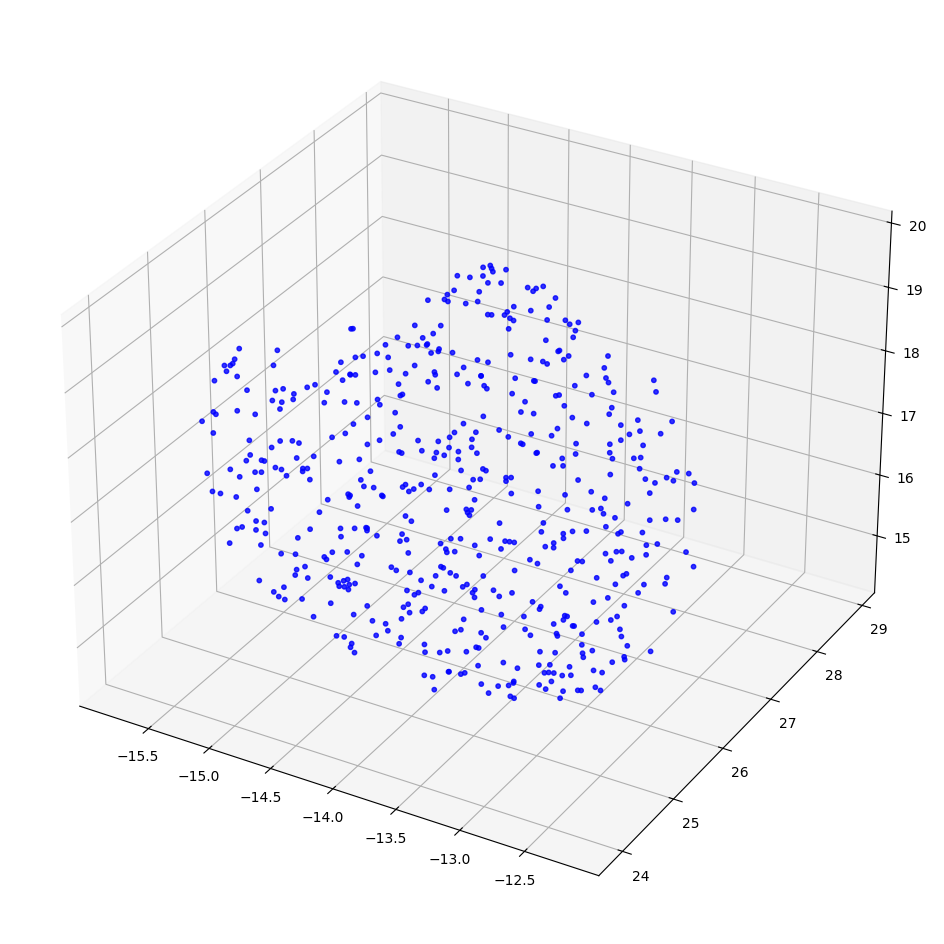

In [42]:
n_neighbors = 170
min_dist = 0.3

plot_umap('colour palettes', colour_palettes, n_neighbors, min_dist)